<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliografia

In [0]:
#urlArchivos = "https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing"

In [0]:
#!pip install tensorflow==2.0.0-alpha0

In [0]:
#https://github.com/jbagnato/machine-learning
#https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python#cnn
#https://www.datacamp.com/community/blog/keras-cheat-sheet
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

# Iniciar Sistema

## Importar Librerias

In [1]:
#importo las librerias que se van a necesitar
import pickle
import matplotlib.pyplot as plt
import numpy as np

from keras import models
from keras import layers

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical #para que las salidas queden parametrizadas en binario

from sklearn.metrics import classification_report #para ver parametros 

from keras.applications.inception_v3 import decode_predictions #para ver varios items de prediccion

#para autoescalar la imagen al tamaño requerido por la red a reentrenar
from keras.applications.inception_v3 import preprocess_input

#Incrementar el número de ejemplos para evitar overfitting (junto con dropout)
#Generar datos a partir de los presentes, a través de transformaciones
from keras.preprocessing.image import ImageDataGenerator



# Para las librerias para la red neuronal
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

#callback para mejorar los entrenamientos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

Using TensorFlow backend.


## Conexion con Google y Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
###################################################################################################
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/Redes Neuronales/'
###################################################################################################

In [0]:
#le indicamos al colaboratory que las importaciones de librerias propias se haran tambien desde el directorio base
import sys
sys.path.append(BASE_FOLDER)

## Importar Librerias propias

In [0]:
from ModeloExterno import ModeloExterno

## Funciones

In [0]:
#Algunas funciones utiles
def plot_image(img, title=""):
    #plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    #plt.axis('off')
    plt.show()

def convertLabelsToNumbers(y_train):
    # Transformando las labels de texto a valores numéricos
    y = np.unique(y_train)
    mapping = { key : value for key,value in zip(y,range(len(y)))}
    processed_y = np.array([mapping[i] for i in y_train])
    #print(len(mapping))
    return processed_y

def DividirDatos_Train_Test_Predic(x, y, porcentaje=0.33, randomDiv=52):
    # dividir los datos entre training, test y predic
    X_train, X_test, y_train, y_test = train_test_split(
        x_train_all, processed_y, 
        test_size=porcentaje, 
        random_state=randomDiv)

    X_test, X_predic, y_test, y_predic = train_test_split(
        X_test, y_test, 
        test_size=porcentaje, 
        random_state=randomDiv)
    
    #Hacemos el One-hot Encoding
    train_Y_one_hot = to_categorical(y_train)
    test_Y_one_hot = to_categorical(y_test)
    predic_Y_one_hot = to_categorical(y_predic)

    return (X_train, train_Y_one_hot), (X_test, test_Y_one_hot), (X_predic, predic_Y_one_hot)

def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['acc'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_pred(pred):
    plt.figure(figsize=(8, 2))
    classes = [c[1] for c in pred]
    probas = [c[2] for c in pred]
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probas, align='center')
    plt.yticks(y_pos, classes)
    plt.gca().invert_yaxis()
    plt.xlabel('Probability')
    plt.xlim(0, 1)

def DefineCallback():
    #EarlyStopping, para que el entrenamiento pare si ve que no mejora la función de coste tras determinados epochs
    early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  

    #ReduceLROnPlateau, que si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
    callbacks_list = [early_stop, reduce_lr]  
    return callbacks_list

## Importar Dataseet y clases

In [8]:
#Cargo los archivos de clases y las imagenes
with open(BASE_FOLDER+"pickle_all_images_df-002.pickle", "rb") as input_file:
    x_train_all = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train_all = pickle.load(input_file)

number_of_classes = len(y_train_all)

print("Entradas: ",x_train_all.shape)
print("Salidas: ", number_of_classes)

Entradas:  (9145, 128, 128, 3)
Salidas:  9145


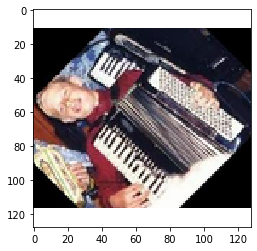

In [9]:
#show image
plot_image(x_train_all[15])

In [10]:
processed_y = convertLabelsToNumbers(y_train_all)
salidasCategoricas = to_categorical(processed_y)

print(len(salidasCategoricas[1]))

classesImageGenerator = np.unique(salidasCategoricas)
nClassesImageGenerator = len(salidasCategoricas[1])
print(nClassesImageGenerator)

102
102


# Aumentar el set de datos con DataGenerator

### Creando el modelo generador de datos

In [0]:
X_train_generator, X_test_generator, y_train_generator, y_test_generator = train_test_split(
        x_train_all, salidasCategoricas, 
        test_size=0.33, 
        random_state=52)

print(X_train_generator.shape, y_train_generator.shape)
print(X_test_generator.shape, y_test_generator.shape)

In [0]:
modelImageGenerator = ModeloExterno(nombreModelo="wisrovi-imageGenerator", rutaBase=BASE_FOLDER)

In [0]:
#Aumentamos el dataset para tener mas datos que procesar
datagen = ImageDataGenerator(
    rotation_range=25, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    shear_range=0.1, # deslizamiento
    zoom_range=0.1, # rango de zoom
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    fill_mode='nearest', # como rellenar posibles nuevos pixeles
    channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)

convnet_augmentation = models.Sequential()
convnet_augmentation.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu', padding='same'))
convnet_augmentation.add(Conv2D(32,(3,3),activation='relu'))
convnet_augmentation.add(MaxPooling2D((2, 2),padding='same'))
convnet_augmentation.add(Dropout(0.5))
convnet_augmentation.add(Conv2D(32,(3,3),activation='relu'))
convnet_augmentation.add(MaxPooling2D((2,2)))
convnet_augmentation.add(Flatten())
convnet_augmentation.add(Dropout(0.25))
convnet_augmentation.add(Dense(32,activation='relu'))
convnet_augmentation.add(Dropout(0.5))
convnet_augmentation.add(Dense(nClassesImageGenerator,activation='softmax'))

convnet_augmentation.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', #para mas de dos clases de clasificación
               metrics=['accuracy'])

convnet_augmentation.summary()

modelImageGenerator.GuardarModelo(convnet_augmentation)

### Preparando y entrenando el modelo Generador de datos

In [0]:
# es necesario especificar el numero de steps cuando se usa un generator (para saber cuando dejar de generar datos en una epoca)
batch_size = 32
num_samples = x_train_all.shape[0] * 10 # multiplicar por 10 el numero de ejemplos
pasos_por_epoca = num_samples//batch_size
iterator_datagen_train = datagen.flow( X_train_generator, y_train_generator,  batch_size=batch_size  )
print(pasos_por_epoca)

numeroEntrenamientos = 30
numeroEpocas = 10
oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history_augmentation = convnet_augmentation.fit_generator(
        iterator_datagen_train,
        epochs=numeroEpocas,
        validation_data=(
            X_test_generator, y_test_generator
        ),
        workers=4,
        steps_per_epoch=pasos_por_epoca,
        callbacks=DefineCallback())
        
    plot_history(history_augmentation)
    


    test_eval = convnet_augmentation.evaluate(X_test_generator, y_test_generator, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modelImageGenerator.GuardarPesosModelo()
        oldModel = convnet_augmentation
    else:
        convnet_augmentation = oldModel

    print("***************")    
    print()

In [0]:
#falta terminar, mirar como con que modelo entrenado puedo generar las imagenes
convnet_augmentation.eva

In [0]:
#falta terminar, mirar como puedo generar las imagenes sin tener que guardarlas en directorio 
#sino guardarlas en los archivos en las fuentes x_train_all y y_train_all
datagen.flow

In [0]:
#falta terminar, buscar que en lugar de guardar en un archivo, guarde el vector
imageGen = datagen.flow(X_test_generator[0], batch_size=1, save_to_dir=args["output"],
	save_prefix="image", save_format="jpg")

for image in imageGen:
	# increment our counter
	total += 1
 
	# if we have reached the specified number of examples, break
	# from the loop
	if total == args["total"]:
		break

# Repartiendo los datos entre Train, test, eval y predic

In [0]:
imagen = 250
#print(processed_y[imagen], y_train_all[imagen])

In [12]:
classes = np.unique(processed_y)
nClasses = len(classes)
print("Numero de clases diferenes:", nClasses)
print()

(X_train, y_train), (X_test, y_test), (X_predic, y_predic) = DividirDatos_Train_Test_Predic(x_train_all, processed_y)

print("Training (66.98%)") 
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print() 
print("Test (22.1%)") 
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print()
print("Predict (10.89%)") 
print("X_predic", X_predic.shape)
print("y_predic", y_predic.shape)

print()
if y_predic.shape[1] == y_test.shape[1] and y_test.shape[1] == y_train.shape[1]:
    print("Distribución correcta")
else:
    print("Fallo en la distribución")

Numero de clases diferenes: 102

Training (66.98%)
X_train (6127, 128, 128, 3)
y_train (6127, 102)

Test (22.1%)
X_test (2022, 128, 128, 3)
y_test (2022, 102)

Predict (10.89%)
X_predic (996, 128, 128, 3)
y_predic (996, 102)

Distribución correcta


In [13]:
#Creamos el Set de Entrenamiento y Validación
#divido los datos de entrenamiento en dos, un 80% para el entrenamiento y otro 20% para validacion
train_X,valid_X,train_label,valid_label = train_test_split(
    X_train, y_train, 
    test_size=0.1, random_state=43)

print("training")
print(train_X.shape)
print(train_label.shape)
print()
print("Valid")
print(valid_X.shape)
print(valid_label.shape)

training
(5514, 128, 128, 3)
(5514, 102)

Valid
(613, 128, 128, 3)
(613, 102)


# Nueva Red Neuronal

## Red Neuronal

In [0]:
modelExtern = ModeloExterno(nombreModelo="wisrovi-nuevoModelo", rutaBase=BASE_FOLDER)

In [15]:
print("********** Modelo *********")

new_model = Sequential()
new_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )
new_model.add(Dense(128, activation='relu'))
new_model.add(MaxPooling2D((2, 2),padding='same'))
new_model.add(Dropout(0.5))

new_model.add(Dense(120, activation='relu'))
new_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(64, activation='relu'))
new_model.add(Flatten()) #para aplanar todas las capas
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(87, activation='relu'))
new_model.add(Dropout(0.5)) #apagar un 50% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Dense(nClasses, activation='softmax')) #Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion

#new_model.summary()

new_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modelExtern.GuardarModelo(new_model)

********** Modelo *********





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Modelo guardado!


True

## Entrenar el modelo



Entrenamiento 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5514 samples, validate on 613 samples
Epoch 1/10





5514/5514 [==============================] - 17s 3ms/step - loss: 4.2469 - acc: 0.1095 - val_loss: 3.5843 - val_acc: 0.2561
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 3.5145 - acc: 0.2695 - val_loss: 3.1922 - val_acc: 0.3377
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 3.2200 - acc: 0.3188 - val_loss: 3.0968 - val_acc: 0.3524
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 3.0473 - acc: 0.3448 - val_loss: 2.9667 - val_acc: 0.3638
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 2.9047 - acc: 0.3618 - val_loss: 2.8362 - val_acc: 0.3703
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 2.7726 - acc: 0.3754 - val_loss: 2.8238 - val_acc: 0.3834
Epoch 7/10
5514/5514 [======

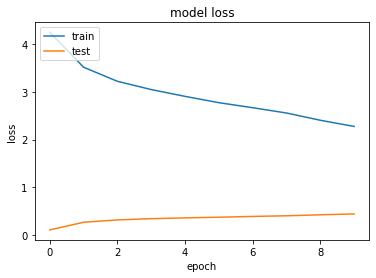

2022/2022 [==============================] - 1s 704us/step
Test loss: 2.6455393221918366
Test accuracy: 0.41196834817012856
Pesos Guardados!
***************



Entrenamiento 2
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 2.0802 - acc: 0.4764 - val_loss: 2.7749 - val_acc: 0.4127
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.9887 - acc: 0.4926 - val_loss: 2.7088 - val_acc: 0.4078
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.8348 - acc: 0.5272 - val_loss: 2.7750 - val_acc: 0.4111
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.7010 - acc: 0.5466 - val_loss: 2.8323 - val_acc: 0.3915
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.5515 - acc: 0.5753 - val_loss: 2.9929 - val_acc: 0.4176
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.4051 - acc: 0.6181 - val_loss

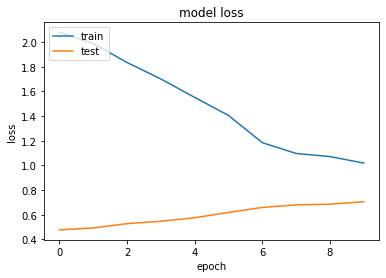

2022/2022 [==============================] - 1s 676us/step
Test loss: 3.605577761294462
Test accuracy: 0.4277942631353139
Pesos Guardados!
***************



Entrenamiento 3
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9758 - acc: 0.7156 - val_loss: 3.5869 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9856 - acc: 0.7124 - val_loss: 3.5804 - val_acc: 0.4258
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9582 - acc: 0.7164 - val_loss: 3.5988 - val_acc: 0.4274
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9597 - acc: 0.7174 - val_loss: 3.6186 - val_acc: 0.4274
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9645 - acc: 0.7200 - val_loss: 3.6164 - val_acc: 0.4241
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9593 - acc: 0.7182 - val_loss: 

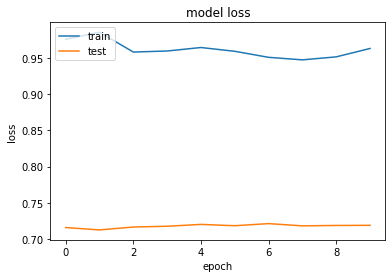

2022/2022 [==============================] - 1s 679us/step
Test loss: 3.6091529332565626
Test accuracy: 0.42532146392660963
***************



Entrenamiento 4
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9660 - acc: 0.7155 - val_loss: 3.6133 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9541 - acc: 0.7156 - val_loss: 3.6135 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9693 - acc: 0.7107 - val_loss: 3.6136 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9590 - acc: 0.7138 - val_loss: 3.6136 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9358 - acc: 0.7214 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 6/10
5514/5514 [=====================

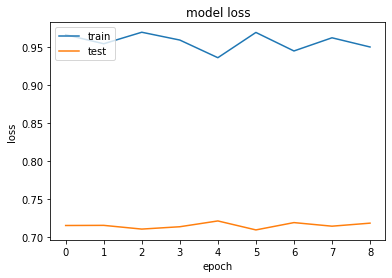

2022/2022 [==============================] - 1s 668us/step
Test loss: 3.6099366563953583
Test accuracy: 0.42532146392660963
***************



Entrenamiento 5
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9390 - acc: 0.7222 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9480 - acc: 0.7234 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9567 - acc: 0.7136 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9638 - acc: 0.7140 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9578 - acc: 0.7160 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 6/10
5514/5514 [=====================

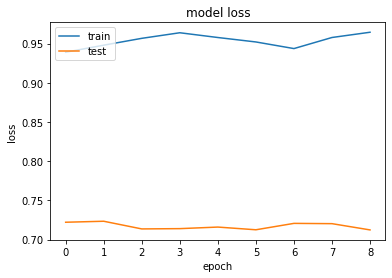

2022/2022 [==============================] - 1s 666us/step
Test loss: 3.609937964278088
Test accuracy: 0.42532146392660963
***************



Entrenamiento 6
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9599 - acc: 0.7185 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9403 - acc: 0.7260 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9431 - acc: 0.7187 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9449 - acc: 0.7205 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9565 - acc: 0.7173 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
Epoch 6/10
5514/5514 [======================

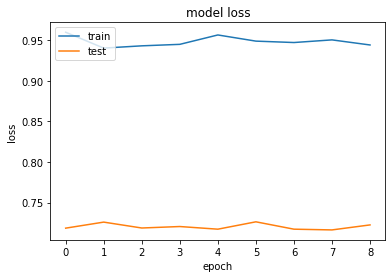

2022/2022 [==============================] - 1s 670us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 7
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9607 - acc: 0.7158 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9662 - acc: 0.7189 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9501 - acc: 0.7187 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9470 - acc: 0.7185 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9534 - acc: 0.7164 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.
Epoch 6/10
5514/5514 [====================

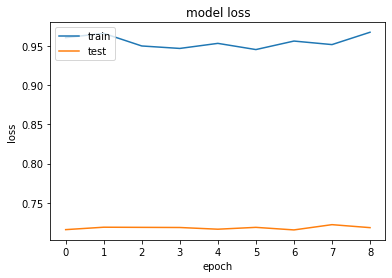

2022/2022 [==============================] - 1s 668us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 8
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9372 - acc: 0.7267 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9449 - acc: 0.7243 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9607 - acc: 0.7120 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9396 - acc: 0.7271 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9321 - acc: 0.7211 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001095066122e-16.
Epoch 6/10
5514/5514 [====================

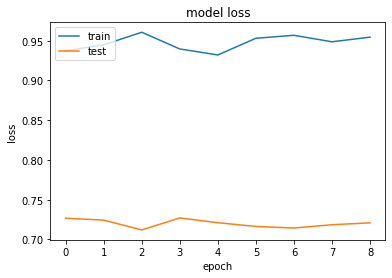

2022/2022 [==============================] - 1s 666us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 9
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9580 - acc: 0.7185 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9410 - acc: 0.7214 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9489 - acc: 0.7151 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9529 - acc: 0.7158 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9452 - acc: 0.7218 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000664932204e-18.
Epoch 6/10
5514/5514 [====================

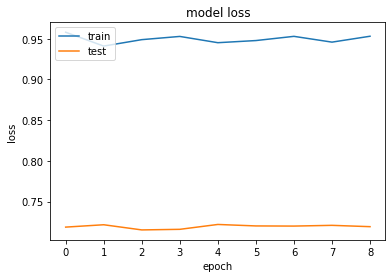

2022/2022 [==============================] - 1s 668us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 10
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9509 - acc: 0.7207 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9735 - acc: 0.7184 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9624 - acc: 0.7185 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9467 - acc: 0.7140 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9549 - acc: 0.7200 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000032889008e-20.
Epoch 6/10
5514/5514 [====================

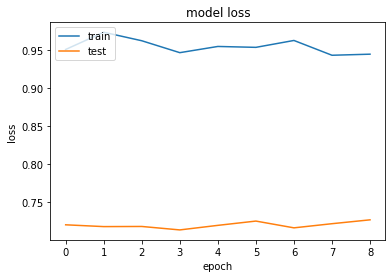

2022/2022 [==============================] - 1s 665us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 11
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9517 - acc: 0.7164 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9471 - acc: 0.7155 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9371 - acc: 0.7213 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9559 - acc: 0.7169 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9419 - acc: 0.7191 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000692397185e-22.
Epoch 6/10
5514/5514 [===================

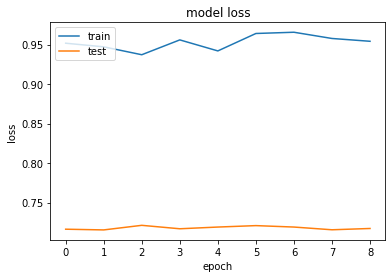

2022/2022 [==============================] - 1s 678us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 12
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9469 - acc: 0.7165 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9482 - acc: 0.7180 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9555 - acc: 0.7180 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9496 - acc: 0.7207 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9485 - acc: 0.7205 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000787060494e-24.
Epoch 6/10
5514/5514 [===================

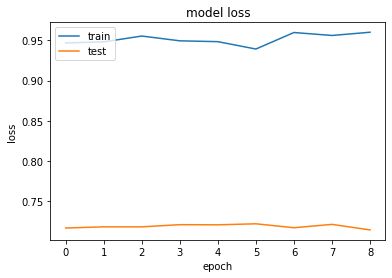

2022/2022 [==============================] - 1s 659us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 13
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9563 - acc: 0.7158 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9354 - acc: 0.7222 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9521 - acc: 0.7165 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9509 - acc: 0.7189 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9714 - acc: 0.7127 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001428009978e-26.
Epoch 6/10
5514/5514 [===================

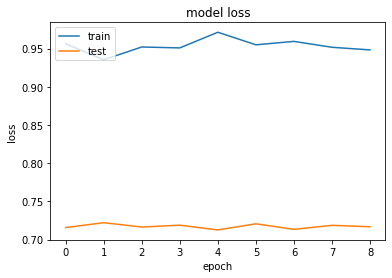

2022/2022 [==============================] - 1s 663us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 14
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9449 - acc: 0.7251 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9693 - acc: 0.7171 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9567 - acc: 0.7178 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9701 - acc: 0.7149 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9591 - acc: 0.7242 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001235416984e-28.
Epoch 6/10
5514/5514 [===================

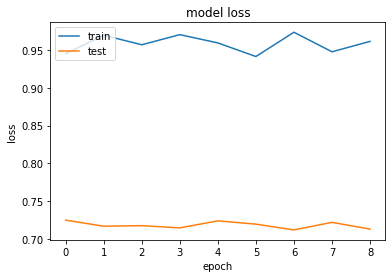

2022/2022 [==============================] - 1s 667us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 15
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9595 - acc: 0.7209 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9647 - acc: 0.7115 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9489 - acc: 0.7165 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9746 - acc: 0.7151 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9462 - acc: 0.7156 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001536343539e-30.
Epoch 6/10
5514/5514 [===================

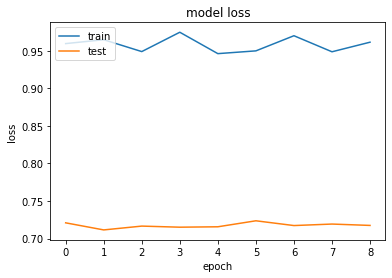

2022/2022 [==============================] - 1s 669us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 16
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9439 - acc: 0.7184 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9534 - acc: 0.7185 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9548 - acc: 0.7207 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9456 - acc: 0.7269 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9606 - acc: 0.7176 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000002147600601e-32.
Epoch 6/10
5514/5514 [===================

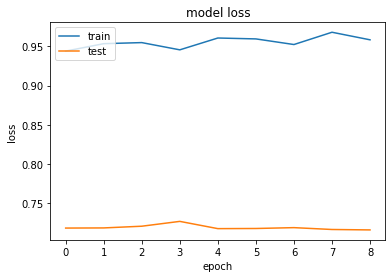

2022/2022 [==============================] - 1s 669us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 17
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9467 - acc: 0.7256 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9627 - acc: 0.7176 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9473 - acc: 0.7231 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9500 - acc: 0.7211 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9575 - acc: 0.7178 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000002074132203e-34.
Epoch 6/10
5514/5514 [===================

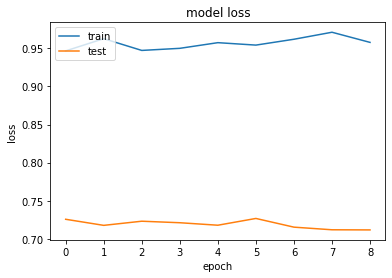

2022/2022 [==============================] - 1s 665us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 18
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9552 - acc: 0.7196 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9489 - acc: 0.7187 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9805 - acc: 0.7091 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9523 - acc: 0.7207 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9626 - acc: 0.7218 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001614954723e-36.
Epoch 6/10
5514/5514 [===================

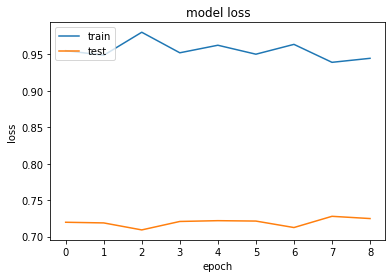

2022/2022 [==============================] - 1s 667us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 19
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9490 - acc: 0.7162 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9506 - acc: 0.7213 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9518 - acc: 0.7218 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9743 - acc: 0.7111 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9471 - acc: 0.7173 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001032014561e-38.
Epoch 6/10
5514/5514 [===================

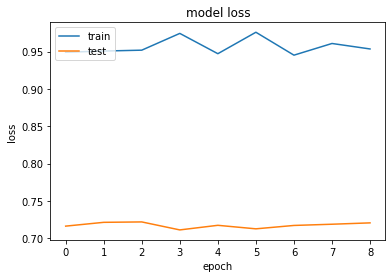

2022/2022 [==============================] - 1s 662us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 20
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9496 - acc: 0.7191 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9539 - acc: 0.7145 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9605 - acc: 0.7185 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9611 - acc: 0.7153 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9539 - acc: 0.7165 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000002153053334e-40.
Epoch 6/10
5514/5514 [===================

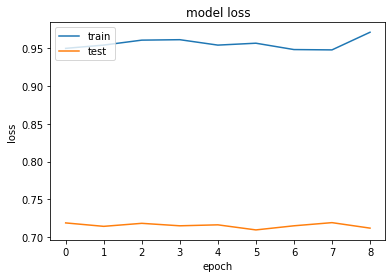

2022/2022 [==============================] - 1s 664us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 21
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9513 - acc: 0.7151 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9720 - acc: 0.7125 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9563 - acc: 0.7173 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9304 - acc: 0.7191 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9653 - acc: 0.7073 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999665841421895e-43.
Epoch 6/10
5514/5514 [====================

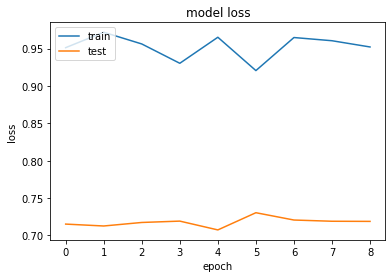

2022/2022 [==============================] - 1s 675us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 22
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9547 - acc: 0.7247 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9542 - acc: 0.7164 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9479 - acc: 0.7198 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9419 - acc: 0.7225 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9502 - acc: 0.7262 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.949219096706202e-45.
Epoch 6/10
5514/5514 [====================

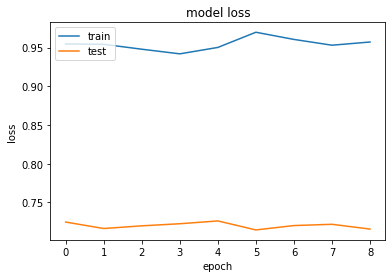

2022/2022 [==============================] - 1s 664us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 23
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9555 - acc: 0.7145 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9627 - acc: 0.7196 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9515 - acc: 0.7213 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9574 - acc: 0.7125 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9410 - acc: 0.7231 - val_loss: 3.6138 - val_acc: 0.4241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.4012984643248171e-46.
Epoch 6/10
5514/5514 [===================

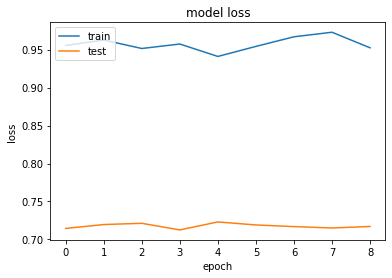

2022/2022 [==============================] - 1s 661us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 24
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9490 - acc: 0.7118 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9435 - acc: 0.7189 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9456 - acc: 0.7211 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9412 - acc: 0.7249 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9538 - acc: 0.7178 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9385 - acc: 0.7202 - val_loss: 3.6138 - val_a

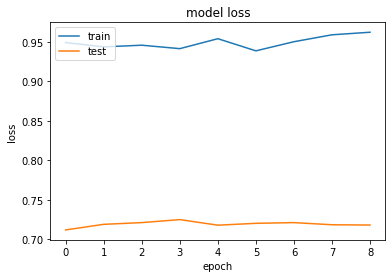

2022/2022 [==============================] - 1s 640us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 25
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9528 - acc: 0.7287 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9637 - acc: 0.7167 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9635 - acc: 0.7140 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9615 - acc: 0.7182 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9540 - acc: 0.7178 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9661 - acc: 0.7131 - val_loss: 3.6138 - val_a

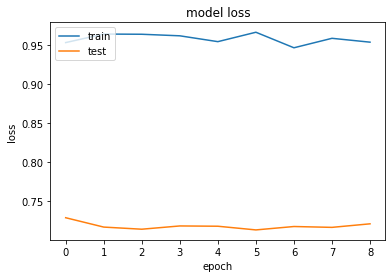

2022/2022 [==============================] - 1s 621us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 26
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9539 - acc: 0.7124 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9389 - acc: 0.7276 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9544 - acc: 0.7189 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9592 - acc: 0.7196 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9510 - acc: 0.7187 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9660 - acc: 0.7086 - val_loss: 3.6138 - val_a

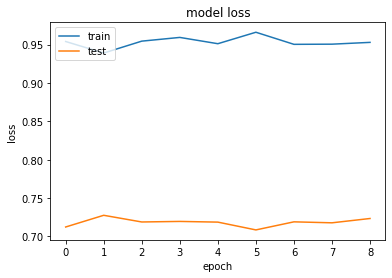

2022/2022 [==============================] - 1s 629us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 27
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9558 - acc: 0.7158 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9510 - acc: 0.7218 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9585 - acc: 0.7200 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9555 - acc: 0.7145 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9579 - acc: 0.7145 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9698 - acc: 0.7140 - val_loss: 3.6138 - val_a

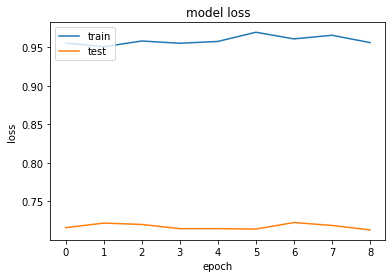

2022/2022 [==============================] - 1s 635us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 28
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9523 - acc: 0.7171 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9569 - acc: 0.7164 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9594 - acc: 0.7196 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9611 - acc: 0.7151 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9588 - acc: 0.7142 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9551 - acc: 0.7165 - val_loss: 3.6138 - val_a

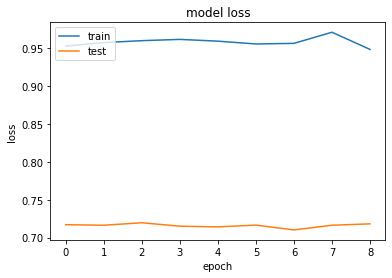

2022/2022 [==============================] - 1s 623us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 29
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9428 - acc: 0.7214 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9523 - acc: 0.7234 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9539 - acc: 0.7211 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9685 - acc: 0.7096 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9549 - acc: 0.7145 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9536 - acc: 0.7203 - val_loss: 3.6138 - val_a

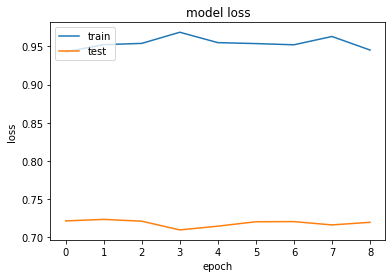

2022/2022 [==============================] - 1s 625us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



Entrenamiento 30
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9412 - acc: 0.7198 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9581 - acc: 0.7173 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9615 - acc: 0.7185 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9559 - acc: 0.7185 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9465 - acc: 0.7124 - val_loss: 3.6138 - val_acc: 0.4241
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9579 - acc: 0.7145 - val_loss: 3.6138 - val_a

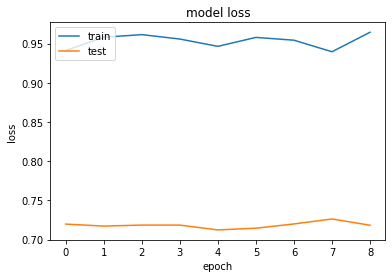

2022/2022 [==============================] - 1s 639us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963
***************



In [16]:
#Entreno el modelo
numeroEntrenamientos = 30 #Al final de cada entrenamiento guardo los mejores pesos
numeroEpocas = 10  #ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = new_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas, 
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback()
        )
        
    plot_history(history)
    
    test_eval = new_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modelExtern.GuardarPesosModelo()
        oldModel = new_model
    else:
        new_model = oldModel
    print("***************")    
    print()

In [17]:
#valido el modelo
test_eval = new_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

2022/2022 [==============================] - 1s 635us/step
Test loss: 3.6099379737110686
Test accuracy: 0.42532146392660963


In [18]:
modelExtern.GuardarPesosModelo()

Pesos Guardados!


True

## Cargar Modelo Red Neuronal Guardado

In [19]:
modeloCargado = modelExtern.CargarModeloGuardado(True)

Lectura del Json del modelo correcta
<class 'str'>
Modelo Cargado!
Pesos Cargados!
Modelo compilado!


In [20]:
#valido el modelo
test_eval = modeloCargado.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

996/996 [==============================] - 1s 845us/step
Test loss: 3.778286756760624
Test accuracy: 0.3985943775100402


# Reentrenar un modelo de ImageNet

## Cargar Modelo ImageNet

In [21]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet


#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, # Si se deben incluir o no las capas de salida originales del modelo
                 input_shape=(128,128,3))

congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 4 layers
  cantidadCapasFinalesDescongelar = 5
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)

conv_base.summary()

58892288/58889256 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f5ee4f75ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f75fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f7d080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ee4f865f8> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f8bc88> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f91780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ee4f994e0> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4f9fc50> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee4fa6d30> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee50b8080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ee5078048> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee50db8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee50e8198> False
<keras.layers.convolutional.Conv2D object at 0x7f5ee50e2e80> F

## Crear nuestro modelo e incluirle el modelo de imageNet

In [0]:
modeloTrasnferenciaConocimiento = ModeloExterno(nombreModelo="wisrovi-transferLearning", rutaBase=BASE_FOLDER)

In [23]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros


pre_trained_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )

#para aplanar todas las capas
#esto se hace debido a que el modelo de VG16 nos da 4 dimensiones de salida, y con esto reducimos las dimensiones a dos: numero datos, numero clases
pre_trained_model.add(Flatten()) 

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros

# conectarlo a nueva parte densa
# Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion
pre_trained_model.add(Dense(nClasses, activation='softmax')) 

pre_trained_model.summary()

# compilar el modelo
pre_trained_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modeloTrasnferenciaConocimiento.GuardarModelo(pre_trained_model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          147488    
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 102)               52326     
Total params: 14,914,502
Trainable params: 7,279,238
Non-trainable params: 7,635,264
___________________________________

True

## Entrenar Modelo Con conocimiento Transferido

Int:  (5514, 128, 128, 3)
Out:  (5514, 102)


Entrenamiento 1
Train on 5514 samples, validate on 613 samples
Epoch 1/15
5514/5514 [==============================] - 9s 2ms/step - loss: 3.2889 - acc: 0.3101 - val_loss: 2.7721 - val_acc: 0.3948
Epoch 2/15
5514/5514 [==============================] - 7s 1ms/step - loss: 2.3242 - acc: 0.4565 - val_loss: 1.8868 - val_acc: 0.5530
Epoch 3/15
5514/5514 [==============================] - 7s 1ms/step - loss: 1.6270 - acc: 0.5903 - val_loss: 1.3434 - val_acc: 0.6444
Epoch 4/15
5514/5514 [==============================] - 7s 1ms/step - loss: 1.2061 - acc: 0.6786 - val_loss: 1.2102 - val_acc: 0.6852
Epoch 5/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.9081 - acc: 0.7543 - val_loss: 1.1199 - val_acc: 0.7243
Epoch 6/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.6670 - acc: 0.8090 - val_loss: 1.1834 - val_acc: 0.7243
Epoch 7/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.5590 - ac

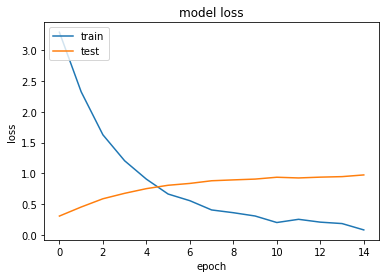

2022/2022 [==============================] - 3s 1ms/step
Test loss: 1.0332909320747345
Test accuracy: 0.804154302611667
Pesos Guardados!
***************



Entrenamiento 2
Train on 5514 samples, validate on 613 samples
Epoch 1/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0371 - acc: 0.9906 - val_loss: 0.9838 - val_acc: 0.7961
Epoch 2/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0375 - acc: 0.9888 - val_loss: 0.9636 - val_acc: 0.8059
Epoch 3/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0223 - acc: 0.9955 - val_loss: 0.9706 - val_acc: 0.8075
Epoch 4/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0211 - acc: 0.9955 - val_loss: 0.9745 - val_acc: 0.8091
Epoch 5/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0189 - acc: 0.9962 - val_loss: 0.9645 - val_acc: 0.8124
Epoch 6/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0171 - acc: 0.9967 - val_loss: 0.

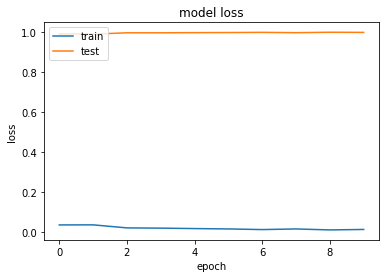

2022/2022 [==============================] - 2s 1ms/step
Test loss: 1.039308207443041
Test accuracy: 0.8189910979818048
Pesos Guardados!
***************



Entrenamiento 3
Train on 5514 samples, validate on 613 samples
Epoch 1/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0141 - acc: 0.9975 - val_loss: 0.9741 - val_acc: 0.8124
Epoch 2/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0139 - acc: 0.9971 - val_loss: 0.9740 - val_acc: 0.8124
Epoch 3/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0141 - acc: 0.9976 - val_loss: 0.9740 - val_acc: 0.8124
Epoch 4/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0110 - acc: 0.9980 - val_loss: 0.9740 - val_acc: 0.8124
Epoch 5/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0133 - acc: 0.9976 - val_loss: 0.9741 - val_acc: 0.8140
Epoch 6/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0161 - acc: 0.9969 - val_loss: 0.

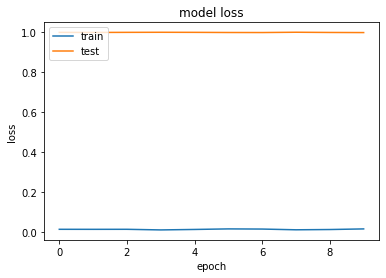

2022/2022 [==============================] - 2s 1ms/step
Test loss: 1.0395373381917483
Test accuracy: 0.8189910979818048
***************



Entrenamiento 4
Train on 5514 samples, validate on 613 samples
Epoch 1/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0150 - acc: 0.9975 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 2/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0152 - acc: 0.9975 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 3/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0156 - acc: 0.9949 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 4/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0131 - acc: 0.9975 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 5/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0125 - acc: 0.9978 - val_loss: 0.9743 - val_acc: 0.8140

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 6/15
5514/5514 [========================

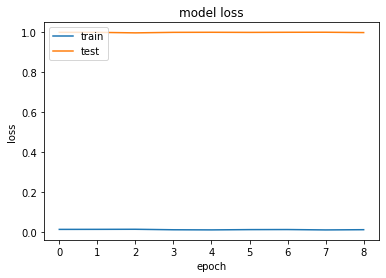

2022/2022 [==============================] - 2s 1ms/step
Test loss: 1.0395244218475388
Test accuracy: 0.8189910979818048
***************



Entrenamiento 5
Train on 5514 samples, validate on 613 samples
Epoch 1/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0132 - acc: 0.9967 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 2/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0145 - acc: 0.9971 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 3/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0148 - acc: 0.9969 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 4/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0112 - acc: 0.9985 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 5/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0119 - acc: 0.9989 - val_loss: 0.9743 - val_acc: 0.8140

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
Epoch 6/15
5514/5514 [========================

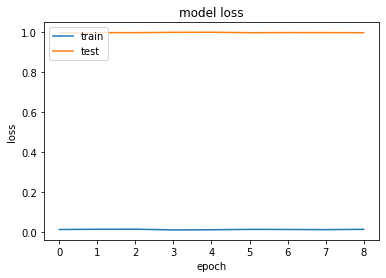

2022/2022 [==============================] - 2s 1ms/step
Test loss: 1.0395245581541053
Test accuracy: 0.8189910979818048
***************



Entrenamiento 6
Train on 5514 samples, validate on 613 samples
Epoch 1/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0136 - acc: 0.9969 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 2/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0145 - acc: 0.9978 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 3/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0121 - acc: 0.9985 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 4/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0117 - acc: 0.9973 - val_loss: 0.9743 - val_acc: 0.8140
Epoch 5/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.0115 - acc: 0.9975 - val_loss: 0.9743 - val_acc: 0.8140

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.
Epoch 6/15
5514/5514 [=======================

In [0]:
#Entreno el modelo

#Al final de cada entrenamiento guardo los mejores pesos
numeroEntrenamientos = 30

#ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
numeroEpocas = 15

#ver datos entrenamiento
print("Int: ", train_X.shape)
print("Out: ", train_label.shape)

oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = pre_trained_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas,        
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback()
        )
        
    plot_history(history)   

    test_eval = pre_trained_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modeloTrasnferenciaConocimiento.GuardarPesosModelo()
        oldModel = pre_trained_model
    else:
        pre_trained_model = oldModel
    print("***************")    
    print()

In [0]:
modeloCargadoTransferenciaConocimiento = modeloTrasnferenciaConocimiento.CargarModeloGuardado(True)

In [0]:
#valido el modelo
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [0]:
url = 'https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/'